In [1]:
import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
from copy import deepcopy
from sklearn.model_selection import StratifiedKFold, KFold, train_test_split
from sklearn.preprocessing import QuantileTransformer
from copy import deepcopy
from lib.data import preprocess
from lib.model import NodeRegressor

import pandas as pd
import numpy as np
np.random.seed(0)


import os
import wget
from pathlib import Path

from matplotlib import pyplot as plt
%matplotlib inline

# Load data and split

In [2]:
out = 'data/train.csv'

In [3]:
df = pd.read_csv(out)

In [4]:
df.loss = np.log(df.loss + 1)

In [5]:
mean = df.loss.mean()
std = df.loss.std()

In [6]:
df.loss = (df.loss - mean) / std

In [7]:
target = 'loss'  # ' <=50K'
if "Set" not in df.columns:
    df["Set"] = np.random.choice(["train", "valid", "test"], p =[.8, .1, .1], size=(df.shape[0],))

train_indices = df[df.Set=="train"].index
valid_indices = df[df.Set=="valid"].index
test_indices = df[df.Set=="test"].index

In [8]:
df.drop(['Set', 'id'], axis=1, inplace=True)
df.fillna(-1, inplace=True)

In [9]:
# train = df.loc[df.Set=="train"].reset_index(drop=True)
# test = df.loc[df.Set=="test"].reset_index(drop=True)

In [10]:
df.head()

,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,...,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss
0,A,B,A,B,A,A,A,A,B,A,...,0.718367,0.335060,0.30260,0.67135,0.83510,0.569745,0.594646,0.822493,0.714843,0.020621
1,A,B,A,A,A,A,A,A,B,B,...,0.438917,0.436585,0.60087,0.35127,0.43919,0.338312,0.366307,0.611431,0.304496,-0.650436
2,A,B,A,A,B,A,A,A,B,B,...,0.289648,0.315545,0.27320,0.26076,0.32446,0.381398,0.373424,0.195709,0.774425,0.397491
3,B,B,A,B,A,A,A,A,B,A,...,0.440945,0.391128,0.31796,0.32128,0.44467,0.327915,0.321570,0.605077,0.602642,-1.034283
4,A,B,A,B,A,A,A,A,B,B,...,0.178193,0.247408,0.24564,0.22089,0.21230,0.204687,0.202213,0.246011,0.432606,0.294381


In [11]:
split_indices = dict(
    train=train_indices,
    valid=valid_indices,
    test=test_indices
)

In [12]:
data = preprocess(df, target='loss', split_indices=split_indices, encoder='cat_encoder',
                  normalize=True, quantile_transform=True, experiment_type='regression',
                  quantile_noise=1e-3)

['cont1', 'cont2', 'cont3', 'cont4', 'cont5', 'cont6', 'cont7', 'cont8', 'cont9', 'cont10', 'cont11', 'cont12', 'cont13', 'cont14']


# Define categorical features for categorical embeddings

# Training

In [15]:
def split_and_preprocess(X_train, y_train, n_splits=5, random_state=0):

    # CVSplit = KFold if self.learning_task == 'regression' else StratifiedKFold
    cv = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    for train_index, test_index in cv.split(X_train, y_train):
        train, test = X_train[train_index], X_train[test_index]
        train, ytr = train, y_train[train_index]
        test, yte = test, y_train[test_index]
        yield train, ytr, test, yte

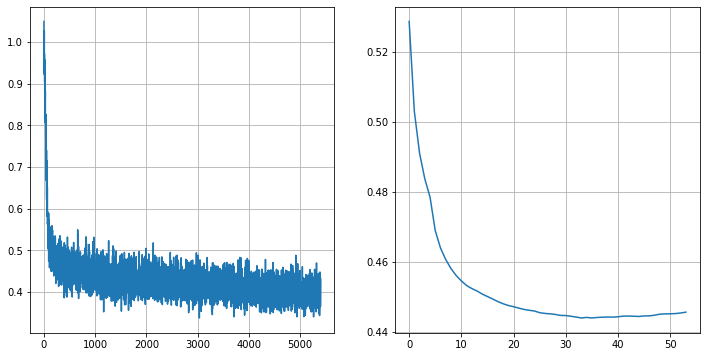

Loss 0.42981
Val mse: 0.44563
BREAK. There is no improvment for 2000 steps
Best step:  3400
Best Val mse: 0.44397
Loaded logs/fold_4/checkpoint_best.pth


In [16]:
clfs = []
for fold, (_train, _ytr, _test, _yte) in enumerate(split_and_preprocess(data['X_train'], data['y_train'])):
    clf = model = NodeRegressor(input_dim=data['X_train'].shape[1], output_dim=1,
                                layer_dim=256, num_layers=1, tree_dim=3,
                                experiment_name=f'fold_{fold}', clean_logs=False)
    clf.fit(
        X_train=_train, y_train=_ytr,
        X_valid=_test, y_valid=_yte,
        early_stopping_rounds=2000,
        report_frequency=100,
        plot=True
    )
    clfs.append(deepcopy(clf))
    torch.cuda.empty_cache()

### Predictions

In [17]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [18]:
for c in clfs:
    preds = c.predict(data['X_test'])
    print(mean_absolute_error(np.exp(data['y_test']*std + mean) - 1, np.exp(preds.flatten()*std + mean) - 1))

1140.999697904238
1138.9322170727073
1136.746753999103
1137.930556593921
1135.9997302966358


In [27]:
preds = 0
for c in clfs:
    preds += (np.exp(c.predict(data['X_test']).flatten()*std + mean) - 1) / len(clfs)
    
test_auc = mean_absolute_error(preds, np.exp(data['y_test']*std + mean) - 1)

print(f"FINAL TEST SCORE: {test_auc}")

FINAL TEST SCORE: 1131.4825669899033
